LCEGP shows strange behavior with the PCS. In theory, adding more training samples
should make the model more accurate, and lead to increased PCS. Although this does not
translate to the Bayesian PCS we use directly, we would still expect to see similar
behavior. This does not always happen with LCEGP, which makes me suspect that it may
have to do with the model fitting.

The goal of this notebook is to analyze the stability of fitting LCEGP using
`fit_gpytorch_model`, and if found to not be stable, come up with better ways of
fitting these models.

One important question is to understand the effects of the initial embedding on the
resulting fitted embedding. I suspect the MLL to be very non-convext in the embedding
and this being the possible reason why we observe these inconsistencies.

### Implemented `custom_fit_gpytorch_model` to get around this issue.

### Some observations made here:
- Increasing the fit tries does help with the noise in fitting.
- Fitting more frequently does help follow the samples more closely.
- A moderate fit tries with a moderate fit frequency sounds like the best option, e.g.,
 5 and 5.

In [49]:
import warnings
from typing import Tuple
warnings.filterwarnings("ignore")

import torch
from botorch import fit_gpytorch_model
from contextual_rs.custom_fit import custom_fit_gpytorch_model
from gpytorch import ExactMarginalLogLikelihood
from torch import Tensor
from torch.distributions import MultivariateNormal

from contextual_rs.lce_gp import LCEGP

%matplotlib inline
import matplotlib.pyplot as plt


Let's train several models on same data and see how the results compare.
Starting with the purely categorical setting.

In [50]:
def test_function(X: Tensor) -> Tensor:
    sine = torch.sin(X)
    linear = X * 0.05
    noise = torch.randn_like(X) * 0.25
    return sine + linear + noise


num_alternatives = 5
num_train = 10
train_X = torch.tensor(
    range(num_alternatives), dtype=torch.float
).repeat(num_train).view(-1, 1)
train_Y = test_function(train_X)

all_alternatives = train_X[:num_alternatives].clone()

num_models = 5
emb_dim = 2
pre_train_embs = torch.zeros(num_models, num_alternatives, emb_dim)
post_train_embs = torch.zeros(num_models, num_alternatives, emb_dim)
post_train_mean = torch.zeros(num_models, num_alternatives)
post_train_covar = torch.zeros(num_models, num_alternatives, num_alternatives)
mll_vals = torch.zeros(num_models)
for i in range(num_models):
    model = LCEGP(
        train_X,
        train_Y,
        categorical_cols=[0],
        embs_dim_list=[emb_dim],
    )
    pre_train_embs[i] = model.emb_layers[0].weight.detach().clone()
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_model(mll)
    post_train_embs[i] = model.emb_layers[0].weight.detach()
    post_train_covar[i] = model.posterior(all_alternatives).mvn.covariance_matrix.detach()
    post_train_mean[i] = model.posterior(all_alternatives).mvn.mean.detach()
    mll_vals[i] = mll(model(train_X), train_Y.squeeze())

In [51]:
pre_train_embs

tensor([[[-0.8938, -1.3415],
         [ 0.6218,  0.2593],
         [-2.3438, -0.8389],
         [-0.3297,  0.2041],
         [-0.9579, -0.1152]],

        [[ 0.9441,  0.9679],
         [-1.3061,  1.7838],
         [ 0.5423,  0.9439],
         [-0.2152, -1.1735],
         [ 0.0657, -1.7044]],

        [[-0.3420,  0.5289],
         [-0.6823, -0.4545],
         [-0.4163, -1.6496],
         [-0.2039, -0.0186],
         [-0.3704, -0.4332]],

        [[ 2.6489,  0.0787],
         [ 2.0840,  0.6403],
         [-0.9468, -0.3605],
         [-0.4155,  0.3447],
         [ 0.2603, -1.5398]],

        [[-0.4197, -1.6602],
         [-0.9366, -0.0533],
         [ 0.2572, -0.2599],
         [ 0.5332, -0.5377],
         [ 1.4906, -0.1815]]])

In [52]:
post_train_embs

tensor([[[-0.8471, -2.6059],
         [-1.6327,  0.0260],
         [-1.0203,  0.0163],
         [-0.4855,  0.2428],
         [ 0.0822,  0.4885]],

        [[ 0.1158, -0.1043],
         [-0.7067,  1.5111],
         [-0.5214,  1.1205],
         [ 0.0121,  0.0853],
         [ 1.1309, -1.7950]],

        [[-0.2357, -0.1264],
         [-0.5943, -0.8007],
         [-0.9075, -1.2328],
         [-0.3067, -0.2493],
         [ 0.0294,  0.3822]],

        [[ 0.2430, -0.2860],
         [ 1.4449,  0.9393],
         [ 0.8846,  0.5620],
         [ 0.2869, -0.1321],
         [ 0.7716, -1.9198]],

        [[ 0.1568, -0.4053],
         [-0.6742, -0.1202],
         [-0.6749, -0.1196],
         [-0.0028, -0.3507],
         [ 2.1396, -1.6984]]])

In [53]:
post_train_covar

tensor([[[ 4.3093e-03,  9.6858e-06,  9.6411e-06, -2.2247e-05,  8.4713e-06],
         [ 9.6560e-06,  2.1099e-03,  2.1099e-03,  1.6129e-04, -7.3433e-05],
         [ 9.6411e-06,  2.1101e-03,  2.1098e-03,  1.6165e-04, -7.3612e-05],
         [-2.2225e-05,  1.6129e-04,  1.6183e-04,  3.7790e-03,  2.8467e-04],
         [ 8.4676e-06, -7.3552e-05, -7.3612e-05,  2.8467e-04,  4.1534e-03]],

        [[ 2.0201e-03, -4.8697e-05, -4.8399e-05,  1.9395e-03,  4.1586e-04],
         [-4.8697e-05,  2.0761e-03,  2.0755e-03,  1.8990e-04, -5.7518e-05],
         [-4.8399e-05,  2.0756e-03,  2.0758e-03,  1.8996e-04, -5.7101e-05],
         [ 1.9393e-03,  1.8990e-04,  1.8996e-04,  2.0682e-03, -1.0610e-04],
         [ 4.1592e-04, -5.7399e-05, -5.7161e-05, -1.0604e-04,  4.0187e-03]],

        [[ 2.0270e-03, -4.4048e-05, -5.0306e-05,  1.9374e-03,  4.1056e-04],
         [-4.3929e-05,  2.0685e-03,  2.0747e-03,  1.9944e-04, -6.0916e-05],
         [-5.0306e-05,  2.0745e-03,  2.0894e-03,  1.7768e-04, -5.4240e-05],
        

In [54]:
post_train_mean

tensor([[ 0.0821,  0.9282,  0.9281,  0.2595, -0.5414],
        [ 0.0807,  0.9290,  0.9289,  0.2588, -0.5408],
        [ 0.0820,  0.9278,  0.9301,  0.2577, -0.5410],
        [ 0.0799,  0.9326,  0.9277,  0.2587, -0.5423],
        [ 0.0808,  0.9283,  0.9289,  0.2590, -0.5402]])

In [55]:
mll_vals

tensor([0.0918, 0.0988, 0.0988, 0.0979, 0.0989], grad_fn=<CopySlices>)

We indeed observe some significant differences in model fits even when we use the same
training data.

Below, we switch to the synthetic MVN as the base function and plot the predicted best
as we add more samples.

In [56]:
def fit_model_on_observations(
    num_alternatives: int,
    rho: float,
    num_full_train: int,
    iterations: int,
    fit_frequency: int,
    custom_fit_tries: int,
    emb_dim: int = 2,
) -> Tensor:
    ckwargs = {"device": "cpu", "dtype": torch.double}
    K = num_alternatives
    true_mean = torch.linspace(0, 1, K, **ckwargs)
    true_cov = torch.zeros(K, K, **ckwargs)
    for i in range(K):
        for j in range(K):
            true_cov[i, j] = torch.tensor(rho, **ckwargs).pow(abs(i - j))
    sampling_post = MultivariateNormal(true_mean, true_cov)

    def fit(retrain: bool):
        nonlocal model
        if retrain:
            model = LCEGP(
                X.view(-1, 1), Y.view(-1, 1), categorical_cols=[0], embs_dim_list=[emb_dim]
            )
            mll = ExactMarginalLogLikelihood(model.likelihood, model)
            custom_fit_gpytorch_model(mll, num_retries=custom_fit_tries)
        else:
            model = model.condition_on_observations(X[-1].view(-1, 1), Y[-1].view(-1, 1))

    X = torch.arange(num_alternatives, **ckwargs).repeat(num_full_train)
    Y = sampling_post.rsample(torch.Size([num_full_train])).view(-1).detach()

    all_alternatives = X[:num_alternatives].view(-1, 1)

    predicted_bests = torch.zeros(iterations, **ckwargs)
    model = LCEGP(X.view(-1, 1), Y.view(-1, 1), [0])
    for i in range(iterations):
        fit(i % fit_frequency == 0)
        predicted_bests[i] = true_mean[model.posterior(all_alternatives).mean.argmax()]
        next_X = torch.randint(0, K, (1,))
        next_Y = sampling_post.rsample()[next_X]
        X = torch.cat([X, next_X], dim=0)
        Y = torch.cat([Y, next_Y], dim=0)
    return predicted_bests

In [57]:
def plot_reps(replications, **kwargs):
    fig = plt.figure(figsize=(12, 8))
    fig.patch.set_facecolor('xkcd:mint green')

    for i in range(replications):
        values = fit_model_on_observations(
            **kwargs
        )
        plt.plot(values, label=f"rep {i}")
    plt.axhline(1, label="true_best")
    plt.grid()
    plt.legend()
    plt.show()

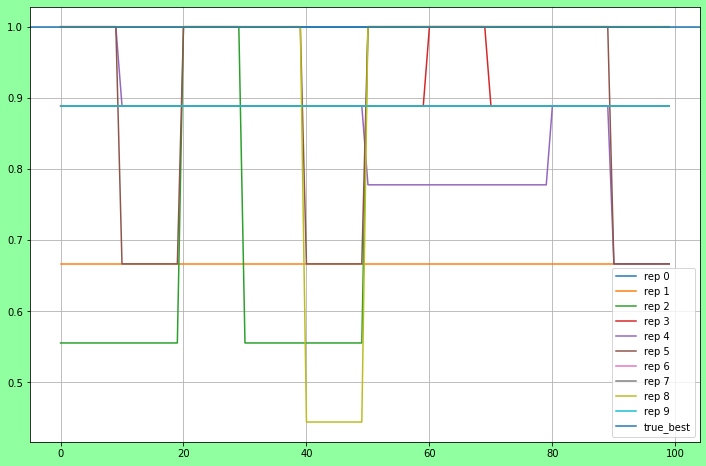

In [58]:
plot_reps(
    replications=10,
    num_alternatives=10,
    rho=0.3,
    num_full_train=5,
    iterations=100,
    fit_frequency=10,
    custom_fit_tries=1,
)

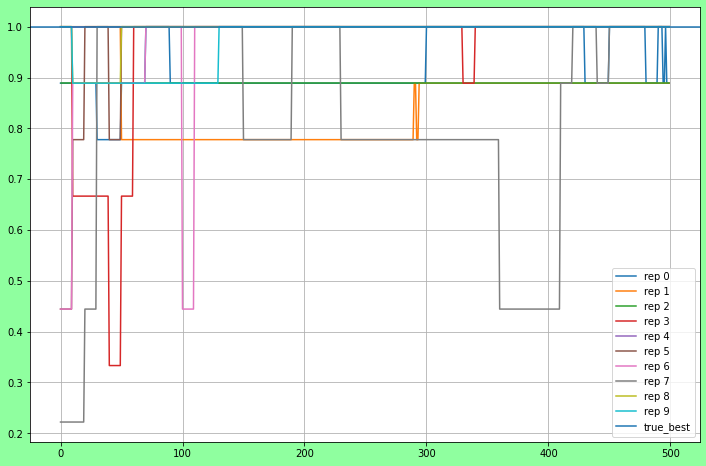

In [59]:
plot_reps(
    replications=10,
    num_alternatives=10,
    rho=0.3,
    num_full_train=5,
    iterations=500,
    fit_frequency=10,
    custom_fit_tries=1,
)

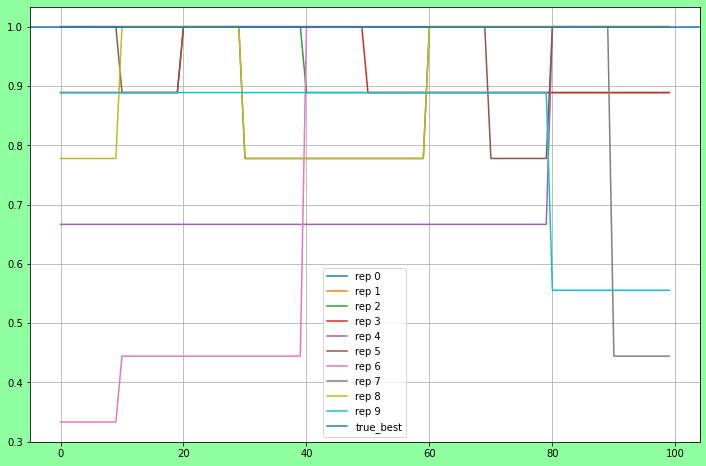

In [60]:
plot_reps(
    replications=10,
    num_alternatives=10,
    rho=0.3,
    num_full_train=5,
    iterations=100,
    fit_frequency=10,
    custom_fit_tries=5,
)

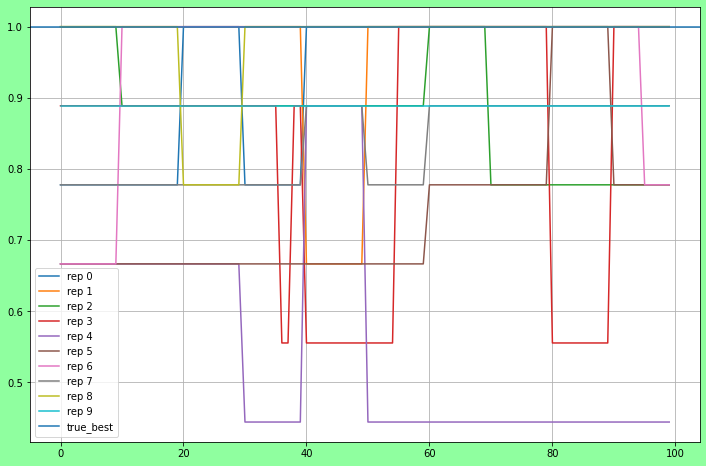

In [61]:
plot_reps(
    replications=10,
    num_alternatives=10,
    rho=0.3,
    num_full_train=5,
    iterations=100,
    fit_frequency=10,
    custom_fit_tries=10,
)

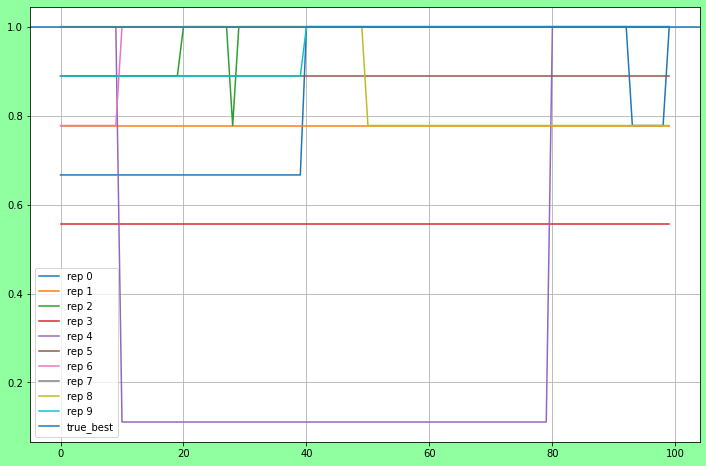

In [62]:
plot_reps(
    replications=10,
    num_alternatives=10,
    rho=0.3,
    num_full_train=5,
    iterations=100,
    fit_frequency=10,
    custom_fit_tries=1,
)

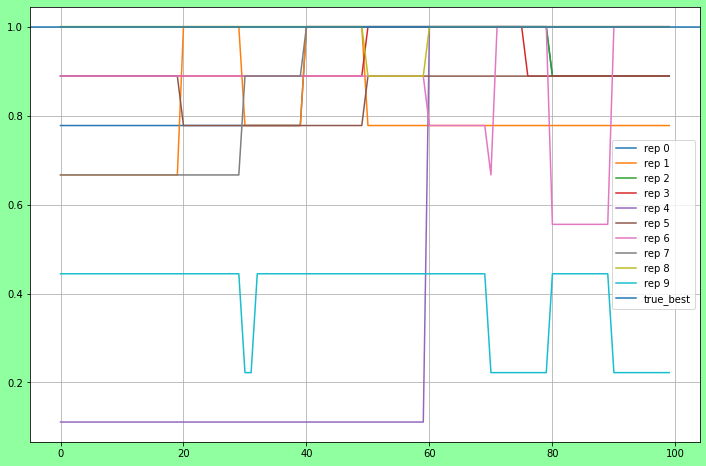

In [63]:
plot_reps(
    replications=10,
    num_alternatives=10,
    rho=0.3,
    num_full_train=5,
    iterations=100,
    fit_frequency=10,
    custom_fit_tries=50,
)

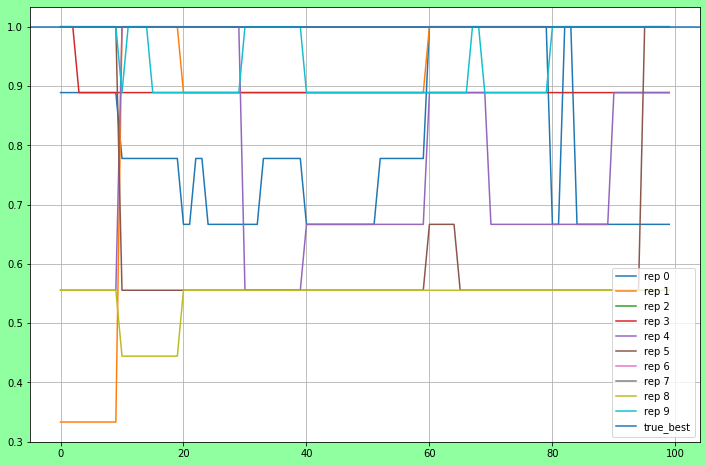

In [64]:
plot_reps(
    replications=10,
    num_alternatives=10,
    rho=0.3,
    num_full_train=5,
    iterations=100,
    fit_frequency=10,
    custom_fit_tries=50,
    emb_dim=1,
)

It is clear that fitting the GP (and the embedding) leads to significant changes in the
predictive posterior.

# TODO: see how the mean of the samples compare. Is it the model or the random samples?

We will plot both the predicted best from the model and the maximizer of the
empirical mean. Using full samples only for now to simplify things.

In [65]:
def fit_model_and_get_sample_best(
    num_alternatives: int,
    rho: float,
    num_full_train: int,
    iterations: int,
    fit_frequency: int,
    custom_fit_tries: int,
    seed: int,
    emb_dim: int = 2,
) -> Tuple[Tensor, Tensor]:
    torch.manual_seed(seed)
    ckwargs = {"device": "cpu", "dtype": torch.double}
    K = num_alternatives
    true_mean = torch.linspace(0, 1, K, **ckwargs)
    true_cov = torch.zeros(K, K, **ckwargs)
    for i in range(K):
        for j in range(K):
            true_cov[i, j] = torch.tensor(rho, **ckwargs).pow(abs(i - j))
    sampling_post = MultivariateNormal(true_mean, true_cov)

    def fit(retrain: bool):
        nonlocal model
        if retrain:
            model = LCEGP(
                X.view(-1, 1), Y.view(-1, 1), categorical_cols=[0], embs_dim_list=[emb_dim]
            )
            mll = ExactMarginalLogLikelihood(model.likelihood, model)
            custom_fit_gpytorch_model(mll, num_retries=custom_fit_tries)
        else:
            model = model.condition_on_observations(X[-1].view(-1, 1), Y.view(-1)[-1].view(-1, 1))

    all_samples = sampling_post.rsample(
        torch.Size([num_full_train + iterations])
    ).view(-1, K).detach()

    X = torch.arange(num_alternatives, **ckwargs).repeat(num_full_train)
    Y = all_samples[:num_full_train]

    all_alternatives = X[:num_alternatives].view(-1, 1)

    predicted_bests = torch.zeros(iterations, **ckwargs)
    empirical_bests = torch.zeros(iterations, **ckwargs)
    model = LCEGP(X.view(-1, 1), Y.view(-1, 1), [0])
    for i in range(iterations):
        fit(i % fit_frequency == 0)
        predicted_bests[i] = true_mean[model.posterior(all_alternatives).mean.argmax()]
        empirical_bests[i] = true_mean[Y.mean(dim=0).argmax()]
        # These two are from a random sample only
        # next_X = torch.randint(0, K, (1,))
        # next_Y = sampling_post.rsample()[next_X]
        next_X = all_alternatives.view(-1)
        next_Y = all_samples[num_full_train + i].view(-1, K)
        X = torch.cat([X, next_X], dim=0)
        Y = torch.cat([Y, next_Y], dim=0)
    return predicted_bests, empirical_bests


def plot_reps_w_empirical(replications, **kwargs):
    fig = plt.figure(figsize=(8, replications+2))
    fig.patch.set_facecolor('xkcd:mint green')
    gs = fig.add_gridspec((replications + 1) // 2, 2, hspace=0.1, wspace=0.2)
    ax = gs.subplots(sharex='col')

    for i in range(replications):
        c_ax = ax[i//2, i%2]
        predicted, empirical = fit_model_and_get_sample_best(**kwargs, seed=i)
        c_ax.plot(predicted, label="predicted")
        c_ax.plot(empirical, label="empirical")
        plt.grid()
    plt.legend()
    plt.show()

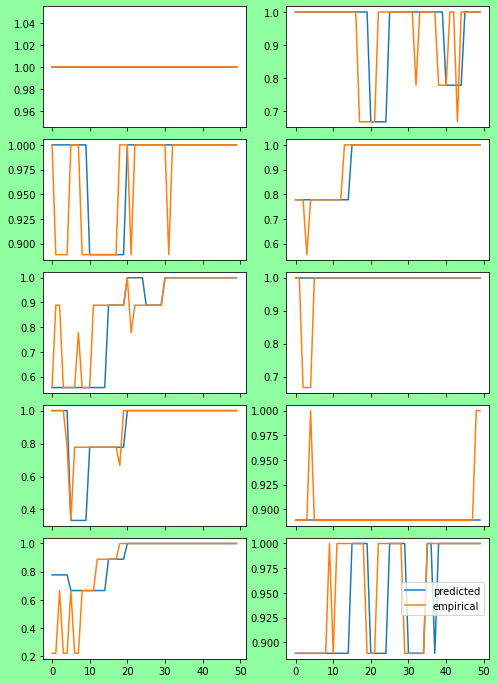

In [66]:
plot_reps_w_empirical(
    replications=10,
    num_alternatives=10,
    rho=0.3,
    num_full_train=5,
    iterations=50,
    fit_frequency=5,
    custom_fit_tries=5,
    emb_dim=1,
)

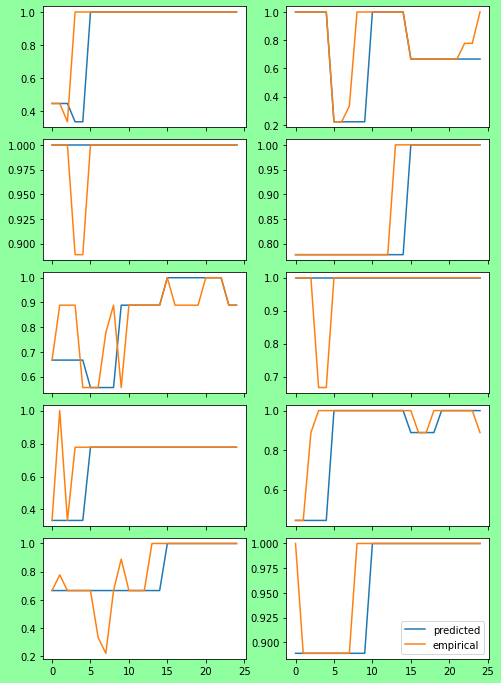

CPU times: user 6min 18s, sys: 2.11 s, total: 6min 20s
Wall time: 1min 14s


In [67]:
kwargs = {
    "replications": 10,
    "num_alternatives": 10,
    "rho": 0.7,
    "num_full_train": 5,
    "iterations": 25,
    "fit_frequency": 5,
    "custom_fit_tries": 5,
    "emb_dim": 1,
}

%time plot_reps_w_empirical(**kwargs)


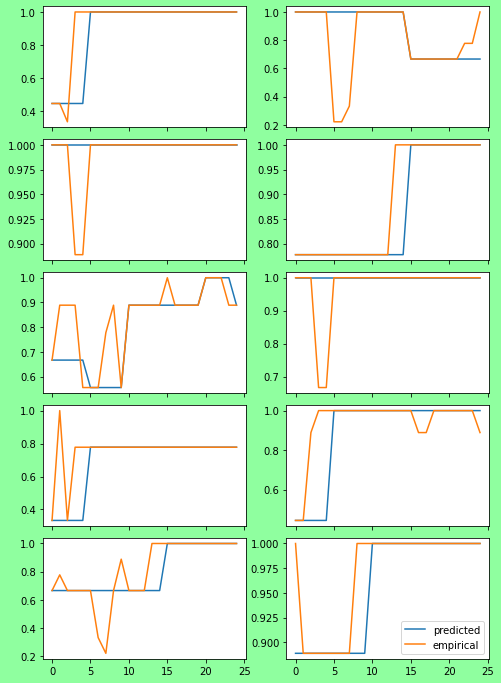

CPU times: user 8min 21s, sys: 3.01 s, total: 8min 25s
Wall time: 1min 34s


In [68]:
kwargs["emb_dim"] = 2

%time plot_reps_w_empirical(**kwargs)

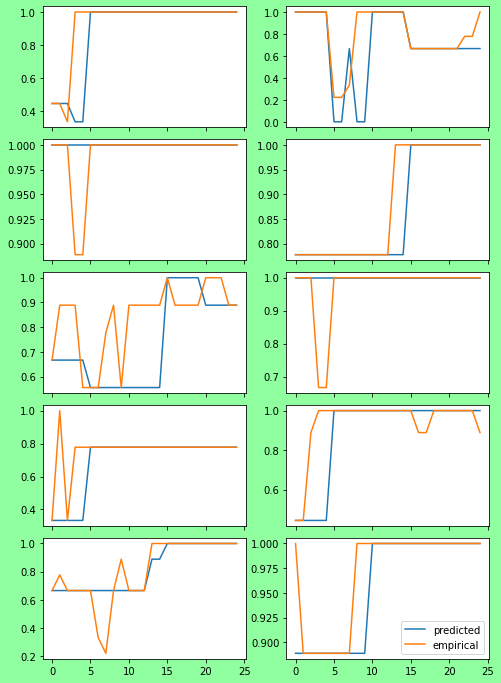

CPU times: user 4min 10s, sys: 1.38 s, total: 4min 12s
Wall time: 45 s


In [69]:
kwargs["custom_fit_tries"] = 1
kwargs["emb_dim"] = 1

%time plot_reps_w_empirical(**kwargs)

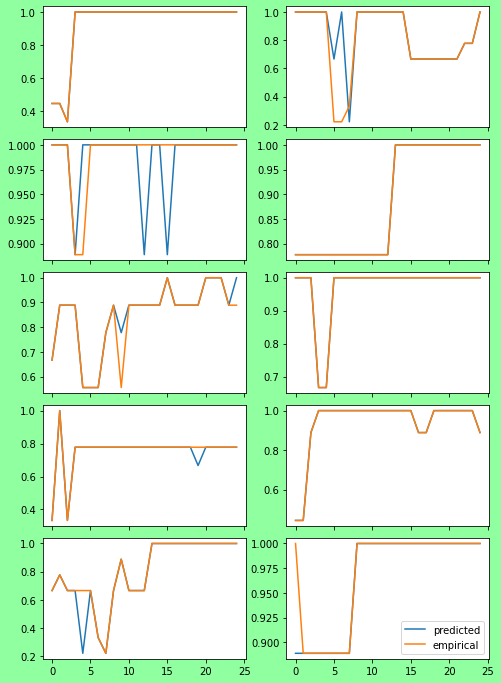

CPU times: user 23min 28s, sys: 9.29 s, total: 23min 37s
Wall time: 4min 6s


In [70]:
kwargs["fit_frequency"] = 1

%time plot_reps_w_empirical(**kwargs)

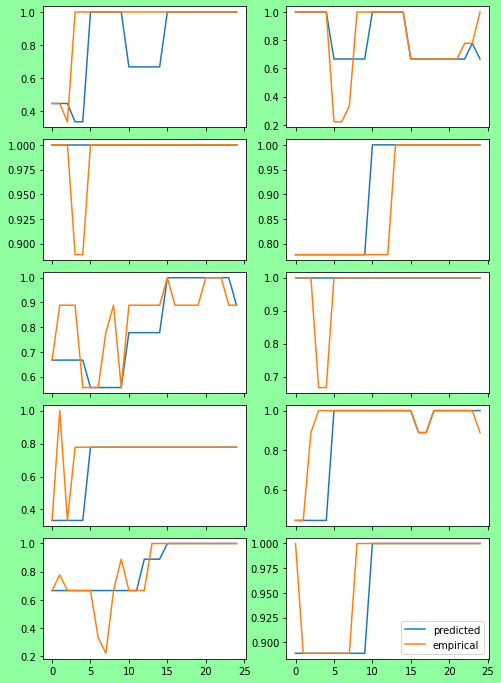

CPU times: user 17min 47s, sys: 6.52 s, total: 17min 53s
Wall time: 3min 40s


In [71]:
kwargs["custom_fit_tries"] = 20
kwargs["fit_frequency"] = 5

%time plot_reps_w_empirical(**kwargs)